## Tag 1: Muster und Algorithmus auswählen
Wählen Sie einen klassischen Bildverarbeitungs
Algorithmus zur Erkennung von Mustern wie Kanten, Linien, Kreisen oder Ecken.
Implementieren Sie jeden relevanten Schritt Ihres Mustererkennungsalgorithmus. Die
einzelnen Schritte des Algorithmus können Sie selbst programmieren oder Bibliotheken verwenden.
Wichtig ist jedoch, dass die jeweiligen Zwischenergebnisse der Schritte
in den Folgeaufgaben demonstriert werden können. Beginnen Sie ein neues Notebook.

(Ich nehme hier bereits, wie in Aufgabe 2 beschrieben ein eigenes Bild)


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Bild laden (Graustufen)
img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Brienzersee.jpg", cv2.IMREAD_GRAYSCALE)

#Gauss-Filter zur Glättung (Rauschreduzierung)
blurred = cv2.GaussianBlur(img, (5, 5), 1.4)

# 2. Gradienten mit Sobel-Operator berechnen
sobel_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude = np.hypot(sobel_x, sobel_y)
gradient_direction = np.arctan2(sobel_y, sobel_x)

#Non-Maximum Suppression (vereinfacht)
def non_max_suppression(magnitude, direction):
    M, N = magnitude.shape
    output = np.zeros((M,N), dtype=np.float32)
    angle = direction * 180. / np.pi
    angle[angle < 0] += 180
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                q = 255
                r = 255

                # Winkelbereiche einteilen
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = magnitude[i, j+1]
                    r = magnitude[i, j-1]
                elif (22.5 <= angle[i,j] < 67.5):
                    q = magnitude[i+1, j-1]
                    r = magnitude[i-1, j+1]
                elif (67.5 <= angle[i,j] < 112.5):
                    q = magnitude[i+1, j]
                    r = magnitude[i-1, j]
                elif (112.5 <= angle[i,j] < 157.5):
                    q = magnitude[i-1, j-1]
                    r = magnitude[i+1, j+1]

                if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                    output[i,j] = magnitude[i,j]
                else:
                    output[i,j] = 0

            except IndexError as e:
                pass

    return output

#Hysterese-Schwellenwertverfahren
def hysteresis(img, low, high):
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.uint8)

    strong = 255
    weak = 75

    strong_i, strong_j = np.where(img >= high)
    weak_i, weak_j = np.where((img <= high) & (img >= low))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    # Verbindung schwacher mit starken Kanten (8-neighbors)
    for i in range(1, M-1):
        for j in range(1, N-1):
            if res[i,j] == weak:
                if ((res[i+1, j-1] == strong) or (res[i+1, j] == strong) or (res[i+1, j+1] == strong)
                    or (res[i, j-1] == strong) or (res[i, j+1] == strong)
                    or (res[i-1, j-1] == strong) or (res[i-1, j] == strong) or (res[i-1, j+1] == strong)):
                    res[i,j] = strong
                else:
                    res[i,j] = 0

    return res

## Bildauswahl
Ich habe ein selbst aufgenommenes Luftbild des Brienzersees gewählt, auf dem im Vordergrund (aus der Flugrichtung gesehen) die beiden Berge Reeti und Schwarzhorn unter dem Flugzeugflügel zu erkennen sind.

Ein potenzieller Stolperstein für den Algorithmus könnte der Flügel sein – dieser ist jedoch bewusst Teil der Problemstellung: Der Algorithmus muss in der Lage sein, den Flügel klar von der Umgebung (See und Bergen) zu unterscheiden. Dies ist entscheidend, wenn das Bild als visuelle Orientierungshilfe für autonome Fluggeräte verwendet werden soll.

## Problemstellung
Bei der Analyse von Luftbildern aus kleinen Flugzeugen oder Drohnen besteht eine zentrale Herausforderung darin, relevante Landschaftsstrukturen wie Bergkämme, Uferlinien oder Täler automatisch zu erkennen – und diese klar von künstlichen Bildanteilen, wie z.B. dem Flugzeugflügel, zu trennen.

Insbesondere bei Bildern, in denen ein Teil des Flugzeugs im Bild sichtbar ist, entsteht das Problem, dass Algorithmen die klaren, geometrischen Kanten des Flügels fälschlicherweise als landschaftlich relevante Kanten interpretieren könnten.

Daher ist es notwendig, ein Verfahren zu entwickeln, das:
- natürliche Kanten (z.B. die Silhouette des Schwarzhorns oder das Seeufer)
- von künstlichen Objekten (z.B. dem Flügel oder Rumpf) automatisch unterscheidet.

Diese Trennung ist essenziell für Anwendungen wie die automatische Orientierung in Flugsystemen oder für die Erstellung verlässlicher topografischer Karten aus Luftbilddaten.

## Anwendungsfall:
In der Luftbildverarbeitung – etwa bei automatisierten Erkennungssystemen in der Kartografie oder beim 3D-Terrain-Mapping – ist die Erkennung natürlicher Kanten (Bergrücken, Gewässergrenzen, Talverläufe) ein zentraler erster Verarbeitungsschritt.

Die extrahierten Informationen können genutzt werden, um:
- Geländeformen zu analysieren
- Höhenprofile zu rekonstruieren
- visuelle Orientierungshilfen für autonome Fluggeräte zu erstellen – insbesondere zur Trennung von fixen Teilen des Fluggeräts (wie dem Flügel) und der Umwelt.

## Warum dieses Bild?
Das Bild bietet eine realistische und komplexe Szene mit vielfältigen Merkmalen:
- Der Flügel als künstliches Objekt mit klaren Kanten
- Der See als homogene Fläche mit deutlicher Uferlinie
- Die Berglandschaft mit unregelmässigen, natürlichen Konturen

Diese Vielfalt macht das Bild ideal zur Demonstration der Schritte eines Mustererkennungsalgorithmus wie dem Canny-Kantendetektor – von der Rauschunterdrückung bis zur finalen Kantenauswahl.

# Tag 3

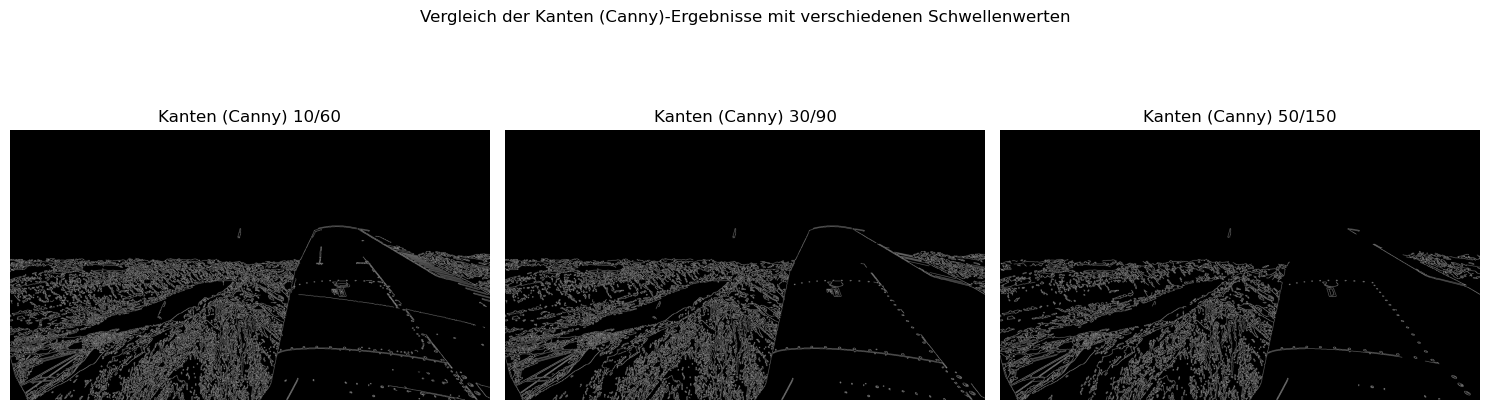

In [16]:
# Bild laden (Graustufen)
img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Brienzersee.jpg", cv2.IMREAD_GRAYSCALE)

#Gauss-Filter zur Glättung (Rauschreduzierung)
blurred = cv2.GaussianBlur(img, (5, 5), 1.4)

# Schwellenwerte definieren
thresholds = [
    (10, 60),
    (30, 90),
    (50, 150)
]

# Plot vorbereiten
plt.figure(figsize=(15, 5))

for i, (low, high) in enumerate(thresholds):
    edges = cv2.Canny(blurred, low, high)
    plt.subplot(1, len(thresholds), i+1)
    plt.imshow(edges, cmap='gray')
    plt.title(f"Kanten (Canny) {low}/{high}")
    plt.axis('off')

plt.suptitle("Vergleich der Kanten (Canny)-Ergebnisse mit verschiedenen Schwellenwerten")
plt.tight_layout()
plt.show()

## Erkenntis zum Threshold-Wert für die Kanntenerkennung
Zur objektiven Bewertung der Schwellenwerte im Canny-Kantendetektor wurden verschiedene Kombinationen getestet und visuell verglichen. Dabei zeigte sich deutlich, wie stark sich die Wahl der Parameter auf das Ergebnis auswirkt.

Bei niedrigen Werten (z.B. low=10, high=60) erkennt der Algorithmus sehr viele feine Kanten. Das führt zwar zu einer hohen Sensitivität, jedoch auch zu einer Vielzahl an unerwünschten Details – insbesondere in Bereichen mit geringer Kontraständerung wie der Wasseroberfläche oder den Wolken. Das Bild wirkt überladen und verrauscht.

Im Gegensatz dazu liefert ein hohes Schwellenwertpaar (z.B. 50/150) sehr selektive Ergebnisse. Hier werden fast ausschliesslich starke Kanten erkannt, wie etwa die Kontur des Flugzeugflügels, solange die Berge darunter ersichtlich sind. Ebenfalls gehen relevante Landschaftsdetails wie Bergkämme oder Uferlinien jedoch weitgehend verloren.

Die Kombination 30/90 stellte sich als besonders ausgewogen heraus: Der Flügel wird zuverlässig erkannt und lässt sich gut von der natürlichen Umgebung trennen. Gleichzeitig bleiben die wichtigsten Landschaftsstrukturen – wie die Silhouetten der Berge und die Uferlinie – erhalten. Damit erfüllt dieses Schwellenwertpaar die Anforderungen der Problemstellung und eignet sich ideal für den geplanten Anwendungsfall.

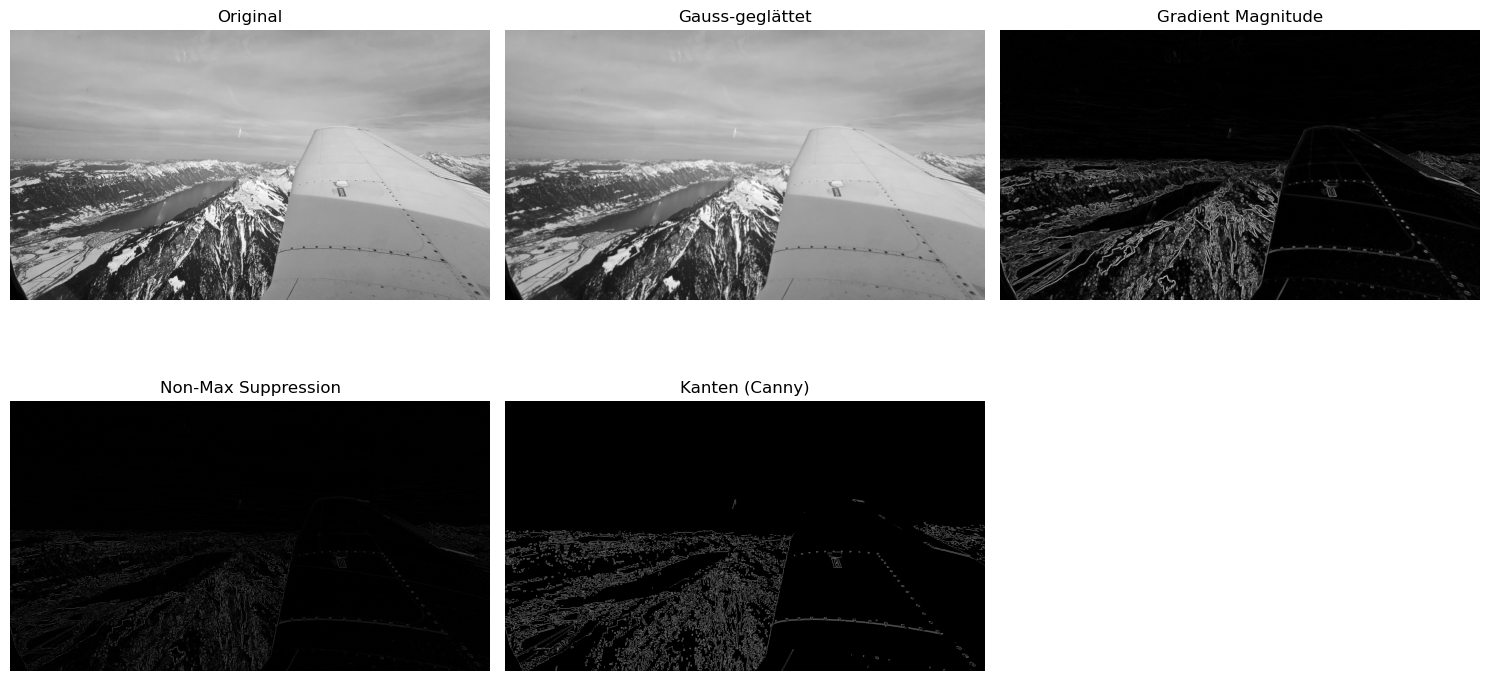

In [14]:
nms = non_max_suppression(gradient_magnitude, gradient_direction)
edges = hysteresis(nms, low=30, high=90)

# Ergebnisse anzeigen
titles = ['Original', 'Gauss-geglättet', 'Gradient Magnitude', 'Non-Max Suppression', 'Kanten (Canny)']
images = [img, blurred, gradient_magnitude, nms, edges]

plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Tag 4
Für die Mustererkennung wurde ein eigenes Luftbild des Brienzersees verwendet, das neben natürlichen Strukturen (Berge, See) auch ein künstliches Objekt – den Flugzeugflügel – enthält. Das Bild wurde bewusst gewählt, da es sowohl komplexe Landschaftsformen als auch geometrisch klare Konturen enthält.

Zur Kantenextraktion wurde der Canny-Algorithmus eingesetzt. Vor der Kantenberechnung wurde das Bild mit einem Gauss-Filter (Kernelgrösse: 5×5, σ=1.4) geglättet, um Rauschen zu reduzieren. Für die Hysterese-Schwellenwerte wurden 30 (low) und 90 (high) gewählt, was sich als ausgewogen für natürliche und künstliche Kanten erwies.

Der Algorithmus erkennt die Silhouetten der Berge und die Uferlinie zuverlässig. Auch der Flugzeugflügel wird als klare Kante identifiziert – was in diesem Fall gewünscht ist, da er vom Algorithmus getrennt von der Umgebung erkannt werden soll. Schwächen zeigt der Algorithmus bei Detailstrukturen in den Wolken und der Wasseroberfläche, da dort die Kontraste oft zu schwach sind.
